In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from scipy import stats
from scipy.optimize import brentq, least_squares

import warnings
warnings.filterwarnings("ignore")

In [3]:
spy_prices = pd.read_csv('SPY_options.csv')
spx_prices = pd.read_csv('SPX_options.csv')
zero_rates = pd.read_csv('zero_rates_20201201.csv')

In [5]:
spy_prices.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,25000,340.74,341.20,A
1,20201201,20201218,C,50000,315.75,316.21,A
2,20201201,20201218,C,75000,290.75,291.21,A


In [6]:
spx_prices.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E


In [8]:
zero_rates.head(5)

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


# Option Pricing Models

In [3]:
def black_scholes_option_pricer(S, K, r, T, sigma, call = True):
    '''
    Function calculates option prices based on Black-scholes model.
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*(T))/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1

    option_values = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return option_values

In [4]:
def displaced_diffusion_option_pricer(F, K, r, T, sigma, beta, call):
    ''' 
    Function calculates option prices based on Displaced-Diffusion Model.
    Three modes available: Vanilla (default), Cash-or-Nothing (CON), Asset-or-Nothing (AON)
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: short rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    beta: parameter to adjust degree of "mixture" between geometric and arithmetic BM
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    # Calculate d1 and d2
    d2 = (np.log(F/(beta*(K+(1-beta)/beta*F))) - (np.square(beta*sigma)*T)/2)/(beta*sigma * np.sqrt(T))
    d1 = d2 + sigma*beta*np.sqrt(T)

    #initializing d1 & d2 for call and put
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1

    #calculating the option values
    option_values = F/beta*scipy.stats.norm.cdf(d1) - (K+(1-beta)/beta*F)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return np.exp(-r*T)*option_values

# Calibrators

In [5]:
def displaced_diffusion_calibration(x, strikes, cp_flag, vols, F, r, T, vol_atm):
    err = 0.0

    for i, K in enumerate(strikes):
        flag = True if cp_flag.iloc[i] == 'C' else False
        dd_price = displaced_diffusion_option_pricer(F, K, r, T, vol_atm, x, call = flag)
        dd_imp_vol = brentq(lambda y: dd_price - black_scholes_option_pricer(F*np.exp(-r*T), K, r, T, y, call = flag),
                                1e-12, 10.0)
        err += (vols.iloc[i] - dd_imp_vol)**2

    return err

In [6]:
def main_DD_calibration(df, exdate, spot):
    df_to_calibrate = df[df['exdate'] == exdate].copy()
    '''
    ATM_Strike_plus = df_to_calibrate[df_to_calibrate['strike_price']>spot]['strike_price'].min()
    ATM_Strike_minus = df_to_calibrate[df_to_calibrate['strike_price']<spot]['strike_price'].max()
    
    ATM_vol_plus = df_to_calibrate[df_to_calibrate['strike_price']== ATM_Strike_plus]['implied_vol'].values[0]
    ATM_vol_minus = df_to_calibrate[df_to_calibrate['strike_price']== ATM_Strike_minus]['implied_vol'].values[0]
    '''
    ATM_vol_plus = df_to_calibrate[df_to_calibrate['strike_price']>spot]['implied_vol'].iloc[0]
    ATM_vol_minus = df_to_calibrate[df_to_calibrate['strike_price']<spot]['implied_vol'].iloc[-1]

    ATM_vol = 0.5*(ATM_vol_plus + ATM_vol_minus)
    
    print('ATM Vol for expiration date {0} is {1}!'.format(exdate, ATM_vol))
    
    DD_guess_0 = [1.0]
    
    DD_res = least_squares(lambda x: displaced_diffusion_calibration(x,
                                                                     df_to_calibrate['strike_price'],
                                                                     df_to_calibrate['cp_flag'],
                                                                     df_to_calibrate['implied_vol'],
                                                                     df_to_calibrate['F'].unique()[0],
                                                                     df_to_calibrate['r'].unique()[0],
                                                                     df_to_calibrate['T'].unique()[0],
                                                                     ATM_vol),
                           DD_guess_0, bounds= (1e-10,1))
    
    DD_beta= DD_res.x[0]
    
    print('Calibrated Displaced-Diffusion model parameters: beta = %.3f' % (DD_beta))
    
    DD_vols = []
    for i, K in enumerate(df_to_calibrate['strike_price']):
            r = df_to_calibrate['r'].iloc[i]
            T = df_to_calibrate['T'].iloc[i]
            flag = True if df_to_calibrate.cp_flag.iloc[i] == 'C' else False
            opt_val = displaced_diffusion_option_pricer(spot,
                                                        K, 
                                                        r, 
                                                        T, 
                                                        ATM_vol, 
                                                        DD_beta, 
                                                        call = flag)
            
            DD_implied_vol = brentq(lambda x: opt_val - black_scholes_option_pricer(spot, 
                                                                                        K, 
                                                                                        r, 
                                                                                        T, 
                                                                                        x, 
                                                                                        call = flag),
                                    1e-12, 10.0)
            DD_vols.append(DD_implied_vol)
    
    return ATM_vol, DD_beta, DD_vols

In [7]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [8]:
def sabrcalibration(x, beta, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes.iloc[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

In [9]:
def main_SABR_calibration(df, exdate, spot):
    df_to_calibrate = df[df['exdate'] == exdate].copy()
    
    F = df_to_calibrate['F'].unique()[0]
    r = df_to_calibrate['r'].unique()[0]
    T = df_to_calibrate['T'].unique()[0]
    
    SABR_beta = 0.7

    SABR_guess_0 = [0.02, 0.2, 0.1]
    SABR_res = least_squares(lambda x: sabrcalibration(x,
                                                       SABR_beta,
                                                       df_to_calibrate['strike_price'],
                                                       df_to_calibrate['implied_vol'],
                                                       F,
                                                       T
                                                      ),
                             SABR_guess_0)
    SABR_alpha = SABR_res.x[0]
    SABR_rho = SABR_res.x[1]
    SABR_nu = SABR_res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (SABR_alpha,
                                                                                                  SABR_beta,
                                                                                                  SABR_rho,
                                                                                                  SABR_nu))

    SABR_vols = []
    
   
    
    for K in df_to_calibrate['strike_price']:
        SABR_vols.append(SABR(F, K, T, SABR_alpha, SABR_beta, SABR_rho, SABR_nu))
        
    return SABR_alpha, SABR_rho, SABR_nu, SABR_vols

# DeAmericanization

In [11]:
def get_divi_matrix(u, d, divi, N):
    logic_matrix_1 = np.ones((N+1,N+1))
    for col in range(N+1):
        if col < divi[1]:
            logic_matrix_1[:, col] = 0
    
    logic_matrix_2 = np.ones((N+1,N+1))
    for col in range(N+1):
        logic_matrix_2[col, :N-col] = u
        logic_matrix_2[col, N-col:] = d
        
    logic_matrix_3 = logic_matrix_1*logic_matrix_2
    logic_matrix_3[:,divi[1]] = 1
    
    multiplier = logic_matrix_3[:,divi[1]:]
    cumulative_multiplier = multiplier.cumprod(axis =1)

    return divi[0] * cumulative_multiplier

In [12]:
def option_binomial_tree(S0, K, r, T, N, u, call = True, opt = 'E', cont_disc = False, full_op = False, divi = (0,0)):
    '''
    Inputs:
    - S0: underlying spot price
    - K: Strike price
    - r: interest rate
    - T: Time to expiration
    - N: Number of discrete time steps
    - u: upstep
    - call: Default: True. if True, the option evaluated is a call option. Otherwise it is a put option.
    - opt: Default: 'E'. Can only take on two values - 'A': American option, or 'E': European option.
    - cont_disc: Default: False. if True, discount factor will be based on continuous discounting.
    - full_op: Default: False. Full output. if True, output return will be a matrix representing the binomial tree.
    - divi: Tuple. Default: (0,0). First item denotes dividend payout amount. Second item denotes ex-date
    '''
    if opt.upper() not in ['A', 'E']:
      print('Option type not recognised! Please indicate "A" or "E" only.')
      return None

    assert N >= divi[1], "Ex-dividend date should occur before terminal date!"
    

    d = 1/u # down-step
    dt = T/N # find discrete time increment

    # Discount factor; two possible types: continuous and discrete time
    disc = np.exp(-r*dt) if cont_disc == True else 1/(1 + r*dt)

    # Risk-neutral probabilities
    p = (1/disc - d)/(u - d)
    
    # Initialize matrix of call values
    # for N discrete time steps, there will be a total of N+1 different terminal states, and N+1 time steps (including time t0)
    C = np.zeros([N+1,N+1])
    
    # Initialize terminal price of asset at maturity T
    
    divi_array = get_divi_matrix(u, d, divi, N)

    
    ST = S0*d**(np.arange(N, -1, -1))* u**(np.arange(0, N+1, 1)) - divi_array[:,-1]
    
    # Get option payout at maturity T
    
    C[:,-1] = np.maximum(0, ST - K if call == True else K - ST)
    
    # backward recursion through the tree
    for i in np.arange(N-1, -1, -1):
        if divi[1] <= i:
            Si = S0*d**(np.arange(i, -1, -1))* u**(np.arange(0, i+1, 1)) - divi_array[:i+1,i - divi[1]]
        else:
            Si = S0*d**(np.arange(i, -1, -1))* u**(np.arange(0, i+1, 1))
        C[:i+1,i] = disc*(p*C[1:i+2,i+1] + (1-p)*C[:i+1,i+1])
        
        if opt == 'A':
            # Recall: if option is American, the value of option at t is the bigger of the discounted value at t+1 or the difference between spot price and strike.
            C[:i+1,i] = np.maximum(C[:i+1,i], Si - K) if call == True else np.maximum(C[:i+1,i], K - Si)
    
    return C if full_op == True else C[0,0]

In [13]:
def get_upside(x, spot, r, T, N):
    S0 = spot
    K = x['strike_price']
    flag = True if x['cp_flag'] == 'C' else False
    american_price = x['mid']
    
    u = brentq(lambda x: option_binomial_tree(S0, K, r, T, N, x,\
                                              call = flag,\
                                              opt = 'A', divi = (1.58, N)) - american_price,
              1.0001, 15.0)
    return u

# Other Misc Functions

In [14]:
def get_zero_rate(df_zr, days_to_expiry):
    days_maturity1, rate1 = df_zr[df_zr['days'] < days_to_expiry].iloc[-1,1:]
    days_maturity2, rate2 = df_zr[df_zr['days'] > days_to_expiry].iloc[0,1:]
    
    return rate1 + (days_to_expiry - days_maturity1)/(days_maturity2 - days_maturity1)*(rate2 - rate1)

In [15]:
def get_AOTM_options(x, spot):
    if x['cp_flag'] == 'C':
        return True if x['strike_price'] >= spot else False
    else:
        return True if x['strike_price'] <= spot else False

In [16]:
def clean_option_data(df_raw, r_dict, spot):
    df = df_raw.copy()
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike_price'] *= 0.001
    
    # Get only ATM and OTM contracts
    df['AOTM'] = df.apply(lambda x: get_AOTM_options(x, spot), axis = 1)
    df = df[df['AOTM'] == True]
    df = df.sort_values(by = 'strike_price')
    
    # Get days to expiry
    df['days_to_expiry'] = (pd.to_datetime(df.exdate, format = '%Y%m%d')-\
                            pd.to_datetime(df.date, format = '%Y%m%d')).dt.days

    df['T'] = df['days_to_expiry']/365
    df['r'] = df['exdate'].apply(lambda x: r_dict[x])
    df['F'] = spot*np.exp(df['r']*df['T'])
    
    return df

In [17]:
def get_implied_volatility(S, option_params):
    # unpack options_params
    payoff = option_params['cp_flag']
    K = option_params['strike_price']
    price = option_params['mid']
    r = option_params['r']
    T = option_params['T']
    
    try:
        if payoff == 'C':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x),
                                1e-12, 10.0)
        elif payoff == 'P':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x,call = False),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized: ', payoff)
    except:
        implied_vol = np.nan
        
    return implied_vol

In [18]:
def plotter(df, DD_vols, SABR_vols, exdate, underlying):
    plt.figure(figsize = (8,4))

    plt.plot(df['strike_price'], df['implied_vol'], 'gs', label='Market Vols')
    plt.plot(df['strike_price'], DD_vols, 'm--', label='SABR Vols')
    plt.plot(df['strike_price'], SABR_vols, '--', label='DD Vols')

   

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title("Implied volatility Smile of {0} options (expiring {1})".format(underlying, exdate))
    plt.legend()
    
    plt.show()

Now calibrate market prices for expiry = 20201218...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20201218 is 0.17440920967285803!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460
Plotting...


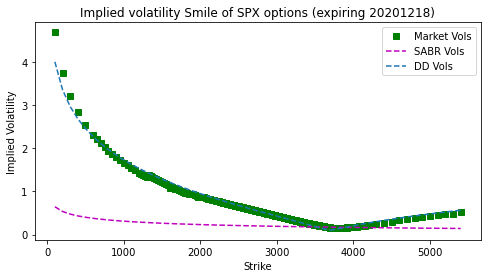

Done!
Now calibrate market prices for expiry = 20210115...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20210115 is 0.18482902747992855!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790
Plotting...


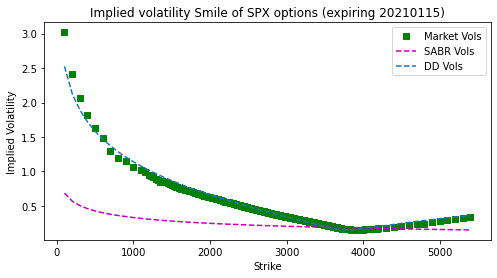

Done!
Now calibrate market prices for expiry = 20210219...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20210219 is 0.19018024351330087!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842
Plotting...


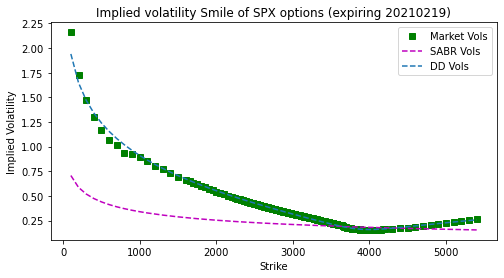

Done!


In [19]:
S_spx = 3662.45
ex_dates = spx_prices.exdate.unique()
underlying = 'SPX'

# Get zero rates for different maturities
r_dict = {}
for ex_date in ex_dates:
    days_to_expiry = (pd.Timestamp(str(ex_date)) - pd.Timestamp('20201201')).days
    r_dict[ex_date] = get_zero_rate(zero_rates, days_to_expiry)/100

# Process df to get essential columns
spx_processed = clean_option_data(spx_prices, r_dict, S_spx)

# Get implied vol
spx_processed['implied_vol'] = spx_processed.apply(lambda x: get_implied_volatility(S_spx, x), axis = 1)
spx_processed.dropna(inplace=True)
spx_cleaned = spx_processed[['exdate', 'mid', 'cp_flag','strike_price', 'implied_vol', 'F', 'r', 'T']].copy()

spx_calibration_res = []

# Calibration
for ex_date in ex_dates:
    print('Now calibrate market prices for expiry = {}...'.format(ex_date))
    res_dict = {'Expiry': ex_date}
    
    print('Displaced-Diffusion Calibration initiated...')
    res_dict['ATM_vol'], res_dict['DD_beta'], res_dict['DD_vols'] = main_DD_calibration(spx_cleaned, ex_date, S_spx)
    
    print('SABR Calibration initiated...')
    res_dict['SABR_alpha'], res_dict['SABR_rho'], res_dict['SABR_nu'], res_dict['SABR_vols'] = main_SABR_calibration(spx_cleaned, ex_date, S_spx)
    
    print('Plotting...')
    plotter(spx_cleaned[spx_cleaned['exdate'] == ex_date],\
            res_dict['DD_vols'],\
            res_dict['SABR_vols'],\
            ex_date,\
            underlying)
    
    spx_calibration_res.append(res_dict)
    
    print('Done!')

In [22]:
pd.DataFrame(spx_calibration_res)

,Expiry,ATM_vol,DD_beta,DD_vols,SABR_alpha,SABR_rho,SABR_nu,SABR_vols
0,20201218,0.174409,5.126286e-08,"[0.6461127586823461, 0.5366909463964952, 0.475...",1.212290,-0.300900,5.459761,"[4.000359644689049, 3.3567371764099403, 2.9650..."
1,20210115,0.184829,1.071745e-10,"[0.6857699608017429, 0.5694689582444872, 0.504...",1.816504,-0.404302,2.790158,"[2.5250508628709545, 2.1324100535220722, 1.893..."
2,20210219,0.190180,1.390187e-07,"[0.7070251966067523, 0.5867225836262205, 0.519...",2.140133,-0.574934,1.841747,"[1.9398364567983892, 1.6476570293436894, 1.470..."


Now calibrate market prices for expiry = 20201218...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20201218 is 0.17548560237255748!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 0.646, beta = 0.7, rho = -0.435, nu = 5.292
Plotting...


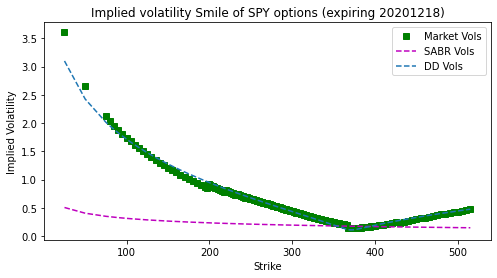

Done!
Now calibrate market prices for expiry = 20210115...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20210115 is 0.1779266493216411!
Calibrated Displaced-Diffusion model parameters: beta = 0.944
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 0.872, beta = 0.7, rho = -0.494, nu = 2.800
Plotting...


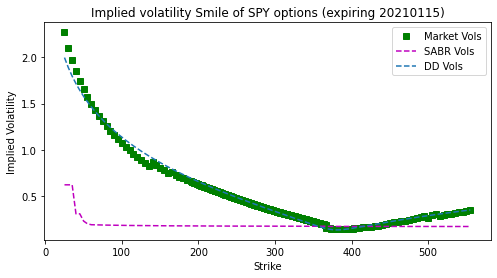

Done!
Now calibrate market prices for expiry = 20210219...
Displaced-Diffusion Calibration initiated...
ATM Vol for expiration date 20210219 is 0.1859740837765283!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
SABR Calibration initiated...
Calibrated SABR model parameters: alpha = 1.104, beta = 0.7, rho = -0.640, nu = 1.770
Plotting...


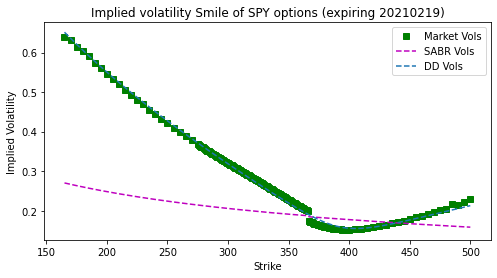

Done!


In [20]:
S_spy = 366.02
ex_dates = spy_prices.exdate.unique()
underlying = 'SPY'

divi = 1.58
ex_divi = (pd.Timestamp('20201218') - pd.Timestamp('20201201')).days

# Get zero rates for different maturities
r_dict = {}
for ex_date in ex_dates:
    days_to_expiry = (pd.Timestamp(str(ex_date)) - pd.Timestamp('20201201')).days
    r_dict[ex_date] = get_zero_rate(zero_rates, days_to_expiry)/100

# Process df to get essential columns
spy_processed = clean_option_data(spy_prices, r_dict, S_spy)

# DeAmericanization
spy_processed['u'] = spy_processed.apply(lambda x: get_upside(x, S_spy, x['r'], x['T'], x['days_to_expiry']), axis = 1)
spy_processed['European Eq Price'] = spy_processed.apply(lambda x: option_binomial_tree(S_spy,
                                                                                        x['strike_price'],
                                                                                        x['r'], 
                                                                                        x['T'], 
                                                                                        x['days_to_expiry'],
                                                                                        x['u'], 
                                                                                        call = (x['cp_flag'] == 'C'), 
                                                                                        divi = (divi, ex_divi)),
                                                         axis = 1)

spy_deAm = spy_processed.copy()
spy_deAm['mid'] = spy_deAm['European Eq Price']

# Get implied vol
spy_deAm['implied_vol'] = spy_deAm.apply(lambda x: get_implied_volatility(S_spy, x), axis = 1)
spy_deAm.dropna(inplace=True)
spy_cleaned = spy_deAm[['exdate', 'mid', 'cp_flag','strike_price', 'implied_vol', 'F', 'r', 'T']].copy()

spy_calibration_res = []

# Calibration
for ex_date in ex_dates:
    print('Now calibrate market prices for expiry = {}...'.format(ex_date))
    res_dict = {'Expiry': ex_date}
    
    print('Displaced-Diffusion Calibration initiated...')
    res_dict['ATM_vol'], res_dict['DD_beta'], res_dict['DD_vols'] = main_DD_calibration(spy_cleaned, ex_date, S_spy)
    
    print('SABR Calibration initiated...')
    res_dict['SABR_alpha'], res_dict['SABR_rho'], res_dict['SABR_nu'], res_dict['SABR_vols'] = main_SABR_calibration(spy_cleaned, ex_date, S_spy)
    
    print('Plotting...')
    plotter(spy_cleaned[spy_cleaned['exdate'] == ex_date],\
            res_dict['DD_vols'],\
            res_dict['SABR_vols'],\
            ex_date,\
            underlying)
    
    spy_calibration_res.append(res_dict)
    
    print('Done!')


In [23]:
pd.DataFrame(spy_calibration_res)

,Expiry,ATM_vol,DD_beta,DD_vols,SABR_alpha,SABR_rho,SABR_nu,SABR_vols
0,20201218,0.175486,6.814426e-07,"[0.5057451872510293, 0.4047401003837684, 0.349...",0.645581,-0.434693,5.292203,"[3.098366150547173, 2.4245986628943057, 2.0140..."
1,20210115,0.177927,9.435184e-01,"[0.625000000002863, 0.625000000002863, 0.62500...",0.871586,-0.493586,2.800048,"[1.9956743551286482, 1.8878500713366144, 1.795..."
2,20210219,0.185974,1.000003e-10,"[0.2701553233295023, 0.26665733189727125, 0.26...",1.104470,-0.640052,1.770444,"[0.6514019715934772, 0.6360086787196392, 0.620..."
